In [30]:
#| echo: false
#| warning: false
#| code-fold: true
#| code-show: "Libraries"

import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.cluster

import json
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot(X,color_vector):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, alpha=0.5) #, c=y
    ax.set(xlabel='Feature-1 (x_1)', ylabel='Feature-2 (x_2)',
    title='Cluster data')
    ax.grid()
    # fig.savefig("test.png")
    plt.show()


In [2]:
#| echo: false
#Feeding in the record label data 

harvard_covid = pd.read_csv("../../data/01-modified-data/harvard_long_covid_cleaned.csv")
# cdc_naive = cdc[['group', 'subgroup', 'value', 'key']]
# cdc_naive['group'] = cdc_naive['group'].astype('category').cat.codes
# cdc_naive['subgroup'] = cdc_naive['subgroup'].astype('category').cat.codes

harvard_covid.head()

,Unnamed: 0,status,sex,response_id,covid_positive,days_acute_covid,hospital_admission,age,bmi,vaccination,...,double_vision,speaking_communication,sleeping,rashes_lumps,anxietydepression,pe,residence,education_level,doses,headache_covid
0,1,Complete,male,67,Yes,Several days:,No,32,26.53376,0,...,0,0,0,1,0,0,1,1,0,0
1,2,Complete,female,87,Yes,Several days:,No,45,30.04326,1,...,0,0,1,1,0,0,4,1,1,0
2,3,Complete,female,89,Yes,Several days:,No,28,29.38476,1,...,0,0,0,0,0,0,3,2,1,0
3,4,Complete,female,124,Yes,Several days:,No,22,18.36547,1,...,0,0,0,0,0,0,3,0,2,1
4,5,Complete,female,127,Yes,Several days:,No,23,25.71101,1,...,0,0,0,0,0,0,2,1,1,1


## Project proposal

- What is the purpose of dimensionality reduction? 
- What is the data that we can using dimensionality reduction on? What are its factors? 
- What is our desired output from the dimensionality reduction? 

## Dimensionality Reduction with PCA

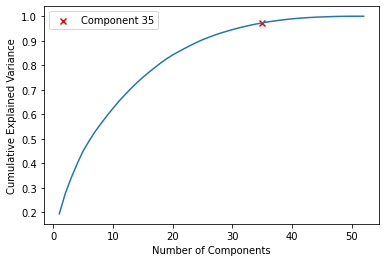

In [13]:
#| echo: true
#| message: false
#| warning: false
#| results: 'hide'
#| code-fold: true
#| code-summary: "{python}"

X = harvard_covid.loc[:, 'age':'headache_covid']

Y = harvard_covid['hospital_admission'].astype('category')

# Standardize the data
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

n_components_test = 52

pca = PCA(n_components = n_components_test)
X_pca = pca.fit_transform(X_transform)

# Plotting the cumulative explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))

# Add a cross at x = 35
threshold_component = 35
threshold_variance = np.cumsum(pca.explained_variance_ratio_)[threshold_component - 1]
plt.scatter(threshold_component, threshold_variance, marker='x', c='red', label=f'Component {threshold_component}')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()


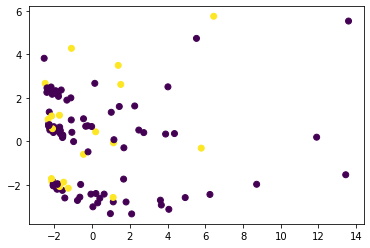

In [14]:

X = harvard_covid.loc[:, 'age':'headache_covid']

Y = harvard_covid['hospital_admission'].astype('category')

Y , _ = pd.factorize(harvard_covid['hospital_admission'])
Y_label = Y.astype(int)

# Standardize the data
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

n_components = 35

pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X_transform)

results = pd.DataFrame({'X1': X_pca[:, 0], 'X2': X_pca[:, 1], 'Y': Y_label})
results

plt.scatter(x = results['X1'], y = results['X2'], c=Y_label)


## Dimensionality Reduction with t-SNE

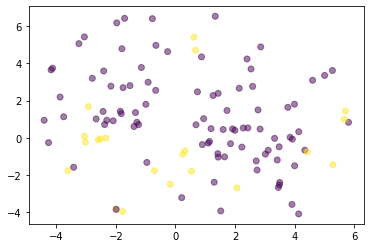

In [21]:
perplexity = 30

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity, random_state=42)

X_tsne = tsne.fit_transform(X_transform)

scatter_tsne = plt.scatter(X_tsne[:,0],X_tsne[:,1], c=Y_label, alpha=0.5)

# Clustering 

## Introduction

## Theory 

## Methods


In [47]:
#| message: false
#| warning: false
#| code-fold: true
#| code-show: "Maximize Silhouette"

def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X)

    # LOOP OVER HYPER-PARAM
    params=[]; 
    sil_scores=[]
    sil_max=-10

    for param in range(2,nmax+1):
        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            param=0.25*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            model = sklearn.cluster.KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(silhouette_score(X,labels))
            params.append(param)
        except:
            continue

        if(i_print): print(param,sil_scores[-1])

        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

**K-MEANS**

OPTIMAL PARAMETER = 2


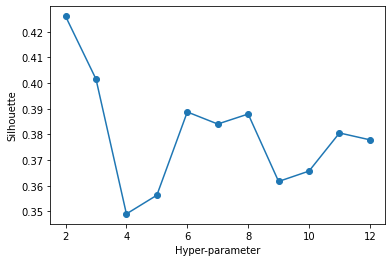

In [48]:
#| message: false
#| warning: false
#| code-fold: true

opt_labels_kmeans = maximize_silhouette(X_tsne, algo="kmeans", nmax=12, i_plot=True)

**DBSCAN**

OPTIMAL PARAMETER = 1.25


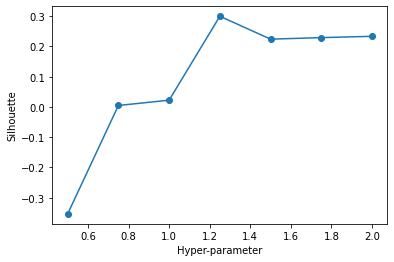

In [49]:
#| message: false
#| warning: false
#| code-fold: true

opt_labels_dbscan = maximize_silhouette(X_tsne, algo="dbscan", nmax=12, i_plot=True)

**HIERARCHICAL**

OPTIMAL PARAMETER = 2


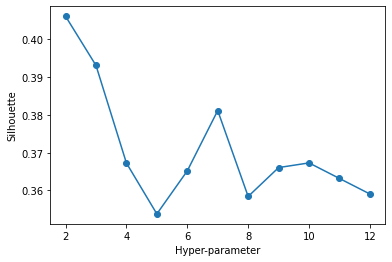

In [50]:
#| message: false
#| warning: false
#| code-fold: true
opt_labels_ag = maximize_silhouette(X_tsne, algo="ag", nmax=12, i_plot=True)

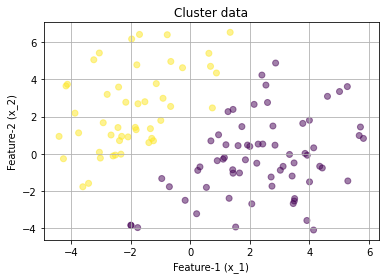

In [53]:
#| message: false
#| warning: false
#| code-fold: true
#| code-show: 'K-Means'

clusters_kmeans = 2
model_kmeans = sklearn.cluster.KMeans(n_clusters=clusters_kmeans).fit(X_tsne)
labels_kmeans = model_kmeans.predict(X_tsne)

plot(X_tsne,labels_kmeans)


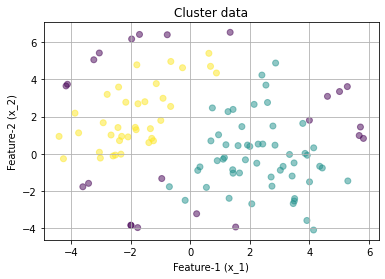

In [54]:
#| message: false
#| warning: false
#| code-fold: true
#| code-show: 'DBSCAN'

clusters_kmeans = 1.25
model_DBSCAN = sklearn.cluster.DBSCAN(eps=clusters_kmeans).fit(X_tsne)
labels_dbscan = model_DBSCAN.labels_

plot(X_tsne,labels_dbscan)

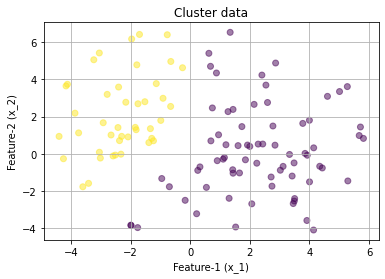

In [55]:
#| message: false
#| warning: false
#| code-fold: true
#| code-show: 'Hierarchical'

clusters_ag = 2
model_AG = sklearn.cluster.AgglomerativeClustering(n_clusters=clusters_ag).fit(X_tsne)
labels_ag = model_AG.labels_

plot(X_tsne,labels_ag)


## Results